# Initialisation

In [40]:
# Import libraries and dependencies
import ccxt
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import talib as ta
import hvplot.pandas


### Import Environment Variables

In [41]:
# Load environment variables
load_dotenv()

# Import environment variables
kraken_public_key = os.getenv("KRAKEN_PUBLIC_KEY")
kraken_secret_key = os.getenv("KRAKEN_SECRET_KEY")

# Verify that environment variables were loaded
print(f"Kraken key data type: {type(kraken_public_key)}")
print(f"Kraken secren data type: {type(kraken_secret_key)}")

Kraken key data type: <class 'str'>
Kraken secren data type: <class 'str'>


### Set Public and private keys and initialise the CCXT Exchange object

In [42]:
# Set the public and private keys for the API
exchange = ccxt.kraken({
    'apiKey': kraken_public_key,
    'secret': kraken_secret_key,
})

if not exchange.has['fetchOHLCV']:
    print('Cant load history data with this exchange. Try with a different exchange')

# Fetching the price data

In [43]:
currs_list = ['ETH/AUD', 'XRP/AUD' , 'LTC/AUD', 'ADA/AUD', 'XLM/AUD', 'BCH/USD']     #

dict_ohlcv = {}

for curr in currs_list:
    
    # Call data fetch
    ohlcv = exchange.fetchOHLCV(curr, '1h')

    # Store the values in a dataframe
    df_ohlcv = pd.DataFrame(ohlcv, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume']).set_index('Date')
    df_ohlcv.index = pd.to_datetime(df_ohlcv.index, unit='ms')

    df_ohlcv.dropna(inplace=True)

    # Store the symbol name and history data in a dict 
    dict_ohlcv[curr] = df_ohlcv 

    print(f'Data for {curr} fetched and appended into the dictionary')


Data for ETH/AUD fetched and appended into the dictionary
Data for XRP/AUD fetched and appended into the dictionary
Data for LTC/AUD fetched and appended into the dictionary
Data for ADA/AUD fetched and appended into the dictionary
Data for XLM/AUD fetched and appended into the dictionary
Data for BCH/USD fetched and appended into the dictionary


# Function Definitions

In [44]:
def add_tech_indicators(df, fast, slow):

#---------------------------------------------------------------------
# Momentum Indicators
#---------------------------------------------------------------------
# SMA indicators fast and slow
    sma_fast = ta.SMA(df['Close'], timeperiod=fast )
    sma_slow = ta.SMA(df['Close'], timeperiod=slow )
    df['SMA_agg'] = sma_fast / sma_slow 

# RSI Ratio
    rsi_fast = ta.RSI(df['Close'], fast)
    rsi_slow = ta.RSI(df['Close'], slow)
    df['RSI_ratio'] = rsi_fast / rsi_slow

# CCI
    df['CCI'] = ta.CCI(df['High'], df['Low'], df['Close'], fast)

#---------------------------------------------------------------------
# Trend Strength Indicators
#---------------------------------------------------------------------
# ADX
    df['ADX'] = ta.ADX(df['High'], df['Low'], df['Close'], timeperiod= fast)
    df['plus_DI'] = ta.PLUS_DI(df['High'], df['Low'], df['Close'], timeperiod= fast)
    df['minus_DI'] = ta.MINUS_DI(df['High'], df['Low'], df['Close'], timeperiod= fast)
    df['ADX_dirn'] = np.where(df['plus_DI'] > df['minus_DI'], 1.0, 0.0)

    df.drop(columns=['plus_DI', 'minus_DI'], inplace=True)

#---------------------------------------------------------------------
# Volatility Indicators
#---------------------------------------------------------------------
# ATR Ratio: fast / slow. if value is less than 1, the price volatility is slowing
    atr_fast = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod= fast)
    atr_slow = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod= slow)
    df['ATR_ratio'] = atr_fast / atr_slow

# Bollinger Bands: periods = fast; Std.Dev = 1
    df['BBands_high'], middle, df['BBands_low']  = ta.BBANDS(df['Close'], timeperiod= fast, nbdevup= 1, nbdevdn= 1)

    df['BBands_high'] = df['BBands_high'] / df['Close']             # Value lesser than 1 will mean price has crossed above upper band
    df['BBands_low'] = df['Close'] / df['BBands_low']               # Value lesser than 1 will mean price has crossed below lower band

    return df

# Computing and adding Technical Indicators to the price data

In [45]:
fast_window = 10
slow_window = 20

df_all_data = pd.DataFrame() 
for curr, data in dict_ohlcv.items():

    df = add_tech_indicators(data, fast_window, slow_window)
    
    df['Currency'] = curr 
    df['Daily_returns'] = df['Close'].pct_change()

    df.dropna(inplace=True)    
    df_all_data = df_all_data.append(df)

df_all_data.shape

(4200, 15)

In [46]:
df_all_data

,Open,High,Low,Close,Volume,SMA_agg,RSI_ratio,CCI,ADX,ADX_dirn,ATR_ratio,BBands_high,BBands_low,Currency,Daily_returns
Date,,,,,,,,,,,,,,,
2021-07-26 04:00:00,3163.95,3186.66,3152.70,3186.66,16.639314,1.019211,1.061462,100.553392,58.241404,1.0,1.280256,0.987162,1.083061,ETH/AUD,0.012911
2021-07-26 05:00:00,3168.59,3190.90,3168.59,3189.39,6.829694,1.023691,1.061651,85.392580,61.209690,1.0,1.254280,0.994731,1.075300,ETH/AUD,0.000857
2021-07-26 06:00:00,3197.56,3251.55,3197.56,3209.02,0.496144,1.028609,1.063108,93.551860,64.189024,1.0,1.296758,0.996287,1.071078,ETH/AUD,0.006155
2021-07-26 07:00:00,3219.74,3219.89,3157.15,3170.70,4.417677,1.032531,0.986993,59.395703,63.837727,1.0,1.324439,1.011395,1.045327,ETH/AUD,-0.011941
2021-07-26 08:00:00,3160.66,3188.00,3160.66,3168.53,18.405586,1.035947,0.982712,45.248884,63.521560,1.0,1.294946,1.012040,1.029206,ETH/AUD,-0.000684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-24 03:00:00,672.45,672.64,670.59,671.55,80.109826,0.993714,0.924816,-24.816531,16.568213,0.0,0.952597,1.008062,1.003250,BCH/USD,0.001925
2021-08-24 04:00:00,671.61,676.48,670.37,676.02,127.935829,0.995314,1.032394,23.205211,15.001808,1.0,0.959194,1.002175,1.008817,BCH/USD,0.006656
2021-08-24 05:00:00,676.31,679.03,675.62,676.43,338.790014,0.997386,1.040488,70.067026,14.459328,1.0,0.940874,1.002090,1.007432,BCH/USD,0.000606


<AxesSubplot:xlabel='Date'>

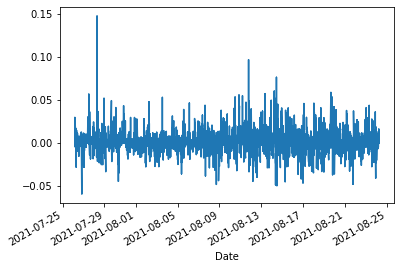

In [48]:
df_all_data.Daily_returns.plot()

In [49]:
df_all_data.to_csv('Resources/Data_plus_indicators.csv')